(0, 100)

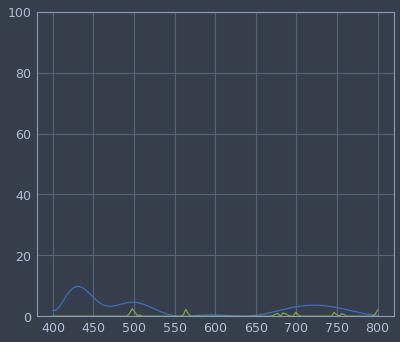

In [630]:
import numpy as np
import mxnet as mx

# Step1: Load the model in MXNet

# Use the same prefix and epoch parameters we used in save_mxnet_model API.
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix='siti_fully', epoch=0)


# We use the data_names and data_shapes returned by save_mxnet_model API.
mod = mx.mod.Module(symbol=sym, 
                    data_names=['/first_input9'], 
                    context=mx.gpu(), 
                    label_names=None)
mod.bind(for_training=False, 
         data_shapes=[('/first_input9', (3,16))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

pt = np.array([ 0.79899497,  1.        , -0.79899497, -0.95979899,  0.42713568,
       -1.        ,  1.        ,  1.        ,  0.63819095, -1.        ,
        1.        , -0.59798995, -0.86934673,  0.68844221, -0.34673367,
       -0.77889447])

ttt = np.tile(pt, (1,1))


# data_iter = mx.io.NDArrayIter(ttt, None, 1)
# res2 = mod.predict(data_iter).asnumpy()
# lams = np.linspace(400, 800, endpoint=True, num=128)
# plt.plot(lams, 100*res2[0])
# plt.xlim([400, 800])
# plt.ylim ( [0,100])
# plt.xlabel('wavelength (nm)')


num_layers = 16
d_min = 0.5
d_max = 100 

#geom = np.random.uniform(0,1, 16)

indexx = np.random.randint(0,100)
geom = (bests_g[indexx]-0.5)/99.5
# geom = np.array([0.99740673, 0.16047267, 0.27205694, 0.28930667, 0.39390871,
#        0.12006336, 0.8       , 0.        , 0.50488817, 0.10512654,
#        0.31236766, 0.8        , 0.07536845, 0.15084873, 0.33889699,
#        0.14410015])
# geom[3] = 1.0
# geom[12] = 1.0
geom_ac = rndtop5(0.5 + 99.5*(geom))
#print(geom_ac)
geom_nor = geom*2 - 1 
geom_nor_t = np.tile(geom_nor, (3,1))

# #best_ac = rndtop5(bests_g)

# indexx = 1
# bests_ac = -1.0 + 2.0*(bests_g - 0.5)/99.5 
# R_gp = 100*mod.predict(bests_ac).asnumpy()


# # # #Rs_b = oqx.tmm_eval_wsweep( best_ac   ,0, lam_pts=128)

Rsmod = 100*mod.predict(geom_nor_t)
Rs2 = Rsmod[0].asnumpy()
 
Rs = oqx.tmm_eval_wsweep( geom_ac   ,0, lam_pts=128)
#Rs = oqx.tmm_eval_wsweep( bests_g[indexx]   ,0, lam_pts=128)

lams = np.linspace(400, 800, endpoint=True, num=128)
plt.plot(lams, Rs)
plt.plot(lams, Rs2)
#plt.plot(lams, R_gp[indexx])
plt.ylim([0,100])

#bests_g

In [286]:
np.random.randint(0,100)

37

In [ ]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
import numpy as np
import de2 as de
import multiprocessing as mp
import makeqx as mkq
import oldqx as oqx
import mxnet.ndarray as nd


def arc_metric(R_arr):
    pop_size = R_arr.shape[0]
    lam_size = R_arr.shape[1]
    R_ref = np.linspace(0.0, 0.0, endpoint=True, num=lam_size)
    R_ref_tiled = np.tile(R_ref, (pop_size, 1))
    return np.mean(np.abs(R_arr - R_ref_tiled), axis=1) 

def bpass_metric(R_arr):
    b_low = 550
    b_high = 600
    pop_size = R_arr.shape[0]
    lam_size = R_arr.shape[1]
    
    lams = np.linspace(400.0, 800.0, endpoint=True, num=lam_size)
    
    left_r = lams[lams < b_low].size
    right_r = lams[lams <= b_high].size
    R_ref = np.linspace(100.0, 100.0, endpoint=True, num=lam_size)
    R_ref[left_r:right_r]  = 0.0
    
    R_ref_tiled = np.tile(R_ref, (pop_size, 1))
    return np.mean(np.abs(R_arr - R_ref_tiled), axis=1) 
    
    diffarr = np.abs(R_arr - R_ref_tiled)
    passb = np.mean(diffarr[:, left_r:right_r], axis=1)
    stopb = np.mean( diffarr[:, 0:left_r -1], axis=1) + np.mean( diffarr[:, right_r + 1:], axis=1)
    return  stopb + passb

# anti-reflection coating
R_ref = np.linspace(100.0, 100.0, endpoint=True, num=50)
# narrow band transmission filter
R_ref[17] = 0.0


def rndtop5(x):
    return np.round(x*2.0)/2

def tmm_wrapper2(arg):
    args, kwargs = arg
    return oqx.tmm_eval_wsweep(*args, **kwargs)


def arc_par_gp(pop, **kwargs):
    x_in = 2.0*(pop - 0.5)/(99.5) - 1.0
    y_in = 100.0*mod.predict(x_in)
    means = nd.mean(y_in, axis=1)
    return means.asnumpy()




def arc_par(pop, **kwargs):
    jobs = []
    pool=mp.Pool(90)
    for indiv in pop:
        #indiv = indiv.reshape((int(indiv.size/2), 2))
        #indiv[:,1] = mkq.digitize_qx(indiv[:,1], dlevels=2)
        indiv = rndtop5(indiv)
        #indiv = indiv.flatten()
        jobs.append((indiv, 0))
    arg = [(j, kwargs) for j in jobs]
    answ = np.array(pool.map(tmm_wrapper2, arg))
    pool.close()

#     c2 = np.zeros(pop.shape[0])
#     for idx, indiv in enumerate(pop):
#         c2[idx] = np.sum(indiv)
#         if c2[idx] <= 385:
#             c2[idx] = 385/c2[idx]
#         else:
#             c2[idx] = 0.0
    return answ
    #return bpass_metric(answ)








bnds = [(d_min, d_max)]*num_layers
its_first = 0
psnew = 5*num_layers
islands = 5
islands_g = islands*psnew 
its_second = 25

isl_g = np.ones((psnew*islands_g, num_layers))
for indiv in range(int(psnew*islands_g)):
    isl_g[indiv] = np.random.uniform(0,1, num_layers)

poplist_g = np.split(isl_g, islands_g)

bids_g = np.zeros(islands_g, dtype=int)
bfits_g = np.zeros(islands_g)
bests_g = isl_g[0:islands_g]

for isln in range(islands_g):
    #print("----------------- I-" + str(isln + 1)+ "---------------------")
    poplist_g[isln], bids_g[isln], bfits_g[isln], bests_g[isln] = de.de_cp(
        fobj=arc_par_gp, bounds=bnds, 
        pop=poplist_g[isln], 
        history=[], 
        it_start=its_first, 
        popsize=psnew, 
        its=its_second, 
        lam_low=400, 
        lam_high=800, 
        lam_pts=128)




its_second = 256
numgens = 3

isl = bests_g
poplist = np.split(isl, islands)

bids = np.zeros(islands, dtype=int)
bfits = np.zeros(islands)
bests = isl[0:islands]



for gen in range(numgens):
    print("==============================")
    print("Epoch #:" + str(gen + 1))
    print("==============================")
    
    for isln in range(islands):
        print("----------------- I-" + str(isln + 1)+ "---------------------")
        
     
        poplist[isln], bids[isln], bfits[isln], bests[isln] = de.de_cp(
            fobj=arc_par, bounds=bnds, 
            pop=poplist[isln], 
            history=[], 
            it_start=its_first, 
            popsize=psnew, 
            its=its_second, 
            lam_low=400, 
            lam_high=800, 
            lam_pts=50)

        
        print(np.sum(bests[isln]))
        
    if its_second > 64:
        its_second = int(its_second/2)
    
    if gen < (numgens - 1):
        print("Round robin best migration")
        stmp = np.copy(poplist[islands-1][bids[islands-1]])
        for isln in range(1, islands):
            poplist[isln][bids[isln]] = poplist[isln-1][bids[isln-1]]
        poplist[0][bids[0]] = stmp 
    
print(bfits) 
print(bests[np.argmin(bfits)])

print(np.sum(bests[np.argmin(bfits)]))

19 2.145484
19 1.7058325
19 1.4603959
19 5.7456036
19 0.71646935
19 3.3900874
19 3.0784802
19 4.498125
19 0.71264493
19 3.0576346
19 1.0986711
19 2.0329676
19 0.5811589
19 3.1673045
19 2.0246377
19 0.39749807
19 2.8259745
19 2.1281688
19 0.9099479
19 2.9248364
19 0.61283654
19 0.58605856
19 1.7281755
19 1.3529438
19 0.6492966
19 3.4086387
19 7.4517274
19 0.98954445
19 2.7845836
19 4.2110662
19 0.23643689
19 4.0419335
19 0.75664216
19 1.8319095
19 2.589772
19 0.83769
19 2.5495431
19 1.6842563
19 2.3059397
19 3.957266
19 3.5410194
19 4.098542
19 2.7205174
19 3.7979965
19 4.8208394
19 3.9352784
19 0.98185545
19 3.7086015
19 1.9990282
19 2.2729812
19 3.83456
19 0.5428893
19 2.6969342
19 1.1999255
19 0.82775193
19 6.21143
19 2.453705
19 0.7821772
19 1.5110769
19 5.336413
19 4.3306212
19 2.5774252
19 4.3692727
19 4.740422
19 2.4539628
19 2.2458973
19 4.664459
19 1.338175
19 4.991782
19 2.0304432
19 0.8794528
19 1.5645689
19 0.90055156
19 2.201878
19 1.5758773
19 3.557377
19 1.4890728
19 4.62

In [635]:
isl.shape

(400, 16)

In [60]:
arc_par(bests_g)

array([1.25103446, 1.78700328, 2.3109896 , 1.11588667, 1.45650532,
       2.74298038, 0.94518088, 1.82786372, 1.93577577, 9.17519445,
       2.25408966, 2.21879332, 1.94204131, 1.86506282, 1.54120511,
       4.07923547, 2.2086548 , 2.32715269, 1.80240239, 1.64751775])

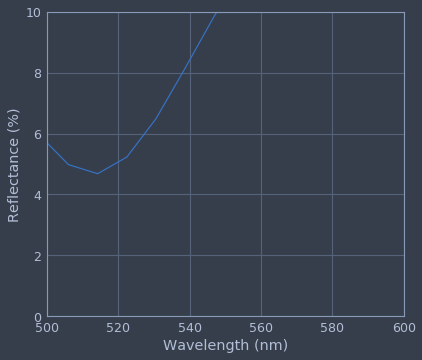

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

#Rs = oqx.tmm_eval_wsweep(rndtop5(bests[np.argmin(bfits)]),0, lam_pts=50)
Rs = oqx.tmm_eval_wsweep(rndtop5(bests_g[ np.random.randint(0,20)  ]),0, lam_pts=50)

#Rs = qn.tmm_eval_wsweep(qx, d_min=2 , d_max=10, inc_ang=0, lam_low=400, lam_high=800, lam_pts=50, n_subs=1.52)  # in nm
lams = np.linspace(400, 800, endpoint=True, num=50)

meanl = np.ones_like(lams)*np.mean(oqx.tmm_eval_wsweep(rndtop5(bests[np.argmin(bfits)]),0))
plt.plot(lams, Rs )
#plt.plot(lams, R_ref)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance (%)')
plt.ylim([0,10])
plt.xlim([500,600])
plt.show()

In [47]:
R_ref = np.linspace(400.0, 800.0, endpoint=True, num=50)
# narrow band transmission filter
#R_ref[0:83] = 0.0
R_ref

array([400.        , 408.16326531, 416.32653061, 424.48979592,
       432.65306122, 440.81632653, 448.97959184, 457.14285714,
       465.30612245, 473.46938776, 481.63265306, 489.79591837,
       497.95918367, 506.12244898, 514.28571429, 522.44897959,
       530.6122449 , 538.7755102 , 546.93877551, 555.10204082,
       563.26530612, 571.42857143, 579.59183673, 587.75510204,
       595.91836735, 604.08163265, 612.24489796, 620.40816327,
       628.57142857, 636.73469388, 644.89795918, 653.06122449,
       661.2244898 , 669.3877551 , 677.55102041, 685.71428571,
       693.87755102, 702.04081633, 710.20408163, 718.36734694,
       726.53061224, 734.69387755, 742.85714286, 751.02040816,
       759.18367347, 767.34693878, 775.51020408, 783.67346939,
       791.83673469, 800.        ])

In [ ]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
import numpy as np
import de2 as de
import multiprocessing as mp
import makeqx as mkq
import qxnew as qn    

def rndtop5(x):
    return np.round(x*2.0)/2

def tmm_wrapper2(arg):
    args, kwargs = arg
    return qn.tmm_eval_wsweep(*args, **kwargs)

def arc_par(pop, **kwargs):
    jobs = []
    pool=mp.Pool(90)
    for indiv in pop:
        indiv = indiv.reshape((int(indiv.size/2), 2))
        indiv[:,1] = mkq.digitize_qx(indiv[:,1], dlevels=2)
        indiv[:,0] = rndtop5(indiv[:,0])
        indiv = indiv.flatten()
        jobs.append((indiv, 0, 1, 0))
    arg = [(j, kwargs) for j in jobs]
    answ = np.array(pool.map(tmm_wrapper2, arg))
    pool.close()
    
    c1 = np.mean(answ, axis=1)
    c2 = np.zeros_like(c1)
    for idx, indiv in enumerate(pop):
        c2[idx] = np.sum(indiv[::2])
        if c2[idx] <= 480:
            c2[idx] = 480/c2[idx]
        else:
            c2[idx] = 0.0
    return c1

    
num_layers = 25
d_min = 0.5
d_max = 20 

bnds = [(d_min, d_max), (0,1)]*num_layers
its_first = 0
psnew = 40
islands = 9
its_second = 256
numgens = 5

isl = np.ones((psnew*islands, 2*num_layers))
for indiv in range(int(psnew*islands)):
    isl[indiv] = np.random.uniform(0,1, 2*num_layers)
    #isl[indiv] = qn.make_qxn(num_layers, dlevels=2)
poplist = np.split(isl, islands)

bids = np.zeros(islands, dtype=int)
bfits = np.zeros(islands)
bests = isl[0:islands]


for gen in range(numgens):
    print("==============================")
    print("Epoch #:" + str(gen + 1))
    print("==============================")
    
    for isln in range(islands):
        print("----------------- I-" + str(isln + 1)+ "---------------------")
        poplist[isln], bids[isln], bfits[isln], bests[isln] = de.de_cp(
            fobj=arc_par, 
            bounds=bnds, 
            pop=poplist[isln], 
            history=[], 
            it_start=its_first, 
            popsize=psnew, 
            its=its_second, 
            lam_low=400, 
            lam_high=800, 
            lam_pts=50)
        print(np.sum(bests[isln][::2]))
    
    if its_second > 64:
        its_second = int(its_second/2)
    
    if gen < (numgens - 1):
        print("Round robin best migration")
        stmp = np.copy(poplist[islands-1][bids[islands-1]])
        for isln in range(1, islands):
            poplist[isln][bids[isln]] = poplist[isln-1][bids[isln-1]]
        poplist[0][bids[0]] = stmp 
    
print(bfits) 
print(bests[np.argmin(bfits)][::2])
print(bests[np.argmin(bfits)][1::2])
print(np.sum(bests[np.argmin(bfits)][::2]))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()
bri = bests[np.argmin(bfits)][1::2]
brx = bests[np.argmin(bfits)][::2]
xarr = np.cumsum(brx)
print(bri)
# plt.plot(xarr, bri)
# plt.show()

In [ ]:
def rndtop5(x):
    return np.round(x*2.0)/2
rndtop5(1.63)

In [ ]:
lams

In [ ]:
lams[88]

In [15]:
a = np.linspace(1, 10, num=10)

In [22]:
left_r = a[a<4].size
right_r = a[a<=8].size
a[left_r:right_r] = 0.0

In [23]:
a

array([ 1.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  9., 10.])